In [1]:
#%matplotlib widget
import pdal
import json
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import transform
from pyproj import Proj, Transformer, CRS
import rioxarray as rio
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
from matplotlib.colors import Normalize
from ipyleaflet import Map, DrawControl, basemaps, GeoJSON, LegendControl
import requests
import pandas as pd
from shapely.geometry import shape
from shapely import Point
import os
import pyproj
from pyproj import CRS, Transformer
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import re
import time
from scipy.interpolate import griddata, Rbf
import geopandas as gpd
from rasterio.mask import mask

## Functions

In [2]:
## From Point Clouds

### Get point clouds through OpenTopography

def geojson_to_wkt(geojson):
    # Ensure the input is a Polygon
    if geojson['type'] != 'Polygon':
        raise ValueError("Input must be a Polygon")

    # Extract coordinates
    coordinates = geojson['coordinates']
    
    # Convert coordinates to WKT string
    wkt_coordinates = ', '.join(
        f"{', '.join(f'{x}, {y}' for x, y in polygon)}"
        for polygon in coordinates
    )
    
    return wkt_coordinates

def search_geojson_by_property_id(geojson_data, value):
    matching_features = []
    for feature in geojson_data['features']:
        if feature['properties']['identifier']['value'] == value:
            matching_features.append(feature)
    return matching_features

def clean_name(name):
    # Remove punctuation and replace spaces with underscores
    cleaned_name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    cleaned_name = re.sub(r'\s+', '_', cleaned_name)  # Replace spaces with underscores
    return cleaned_name

def build_aws_pdal_pipeline(extent_epsg3857, property_ids, pc_resolution, data_source = "noaa", filterNoise = False,
                        reclassify = False, savePointCloud = True, outCRS = 3857, pc_outName = 'filter_test', 
                        pc_outType = 'laz'):

    """
    Build pdal pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage' 
    in the final pdal pipeline. Each stages is appended to the 'pointcloud_pipeline' object to produce the final pipeline.
    
    Parameters:
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857)Polygon is generated 
                            either through the 'handle_draw' methor or by inputing their own shapefile.
    :param usgs_3dep_dataset_names: List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                determined through intersecttino of the 3DEP and AOI polys.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:
        
                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.
                            
    :param filterNoise: Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    :param savePointCloud: Option to save (or not) the point cloud data. If savePointCloud == False, 
           the pc_outName and pc_outType parameters are not used and can be any value.
    :param outCRS: Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    :raise Exception: If user passes in argument that is not 'las' or 'laz'.
    """
    
    #this is the basic pipeline which only accesses the 3DEP data
    readers = []
    for id in property_ids:
        if data_source == 'usgs':
            url = f"https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{id}/ept.json"
        elif data_source == 'noaa':
            stac_url = f"https://noaa-nos-coastal-lidar-pds.s3.amazonaws.com/entwine/stac/DigitalCoast_mission_{id}.json"
            response = requests.get(stac_url)
            data = response.json()
            url = data['assets']['ept']['href']
        else:
            raise ValueError("Invalid dataset source. Must be 'usgs' or 'noaa'.")

        reader = {
            "type": "readers.ept",
            "filename": str(url),
            "polygon": str(extent_epsg3857),
            "requests": 3,
            "resolution": pc_resolution
        }
        readers.append(reader)
        
    pointcloud_pipeline = {
            "pipeline":
                readers
    }
    
    if filterNoise == True:
        
        filter_stage = {
            "type":"filters.range",
            "limits":"Classification![7:7], Classification![18:18]"
        }
        
        pointcloud_pipeline['pipeline'].append(filter_stage)
    
    if reclassify == True:
        
        remove_classes_stage = {
            "type":"filters.assign",
            "value":"Classification = 0"
        }
        
        classify_ground_stage = {
            "type":"filters.smrf"
        }
        
        reclass_stage = {
            "type":"filters.range",
            "limits":"Classification[2:2]"
        }

    
        pointcloud_pipeline['pipeline'].append(remove_classes_stage)
        pointcloud_pipeline['pipeline'].append(classify_ground_stage)
        pointcloud_pipeline['pipeline'].append(reclass_stage)
        
    reprojection_stage = {
        "type":"filters.reprojection",
        "out_srs":"EPSG:{}".format(outCRS)
    }
    
    pointcloud_pipeline['pipeline'].append(reprojection_stage)
    
    if savePointCloud == True:
        
        if pc_outType == 'las':
            savePC_stage = {
                "type": "writers.las",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        elif pc_outType == 'laz':    
            savePC_stage = {
                "type": "writers.las",
                "compression": "laszip",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        else:
            raise Exception("pc_outType must be 'las' or 'laz'.")

        pointcloud_pipeline['pipeline'].append(savePC_stage)
        
    return pointcloud_pipeline

def make_DEM_pipeline_aws(extent_epsg3857, property_ids, pc_resolution, dem_resolution, data_source = "noaa",
                      filterNoise = True, reclassify = True, savePointCloud = False, outCRS = 3857,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = 'dem_test', dem_outExt = 'tif', driver = "GTiff"):
    
    """
    Build pdal pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain (bare earth) model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. 

    The `build_pdal_pipeline() method is used to request the data from the Amazon Web Services ept bucket, and the 
    user may define any processing steps (filtering, reclassifying, reprojecting). The user must also specify whether 
    the point cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857). Polygon is generated 
                         either through the 'handle_draw' methor or by inputing their own shapefile.
                         This parameter is set automatically when the user-defined AOI is chosen.
    :param usgs_3dep_dataset_names: List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                determined through intersecttino of the 3DEP and AOI polys.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:

                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.


   
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    :raise Exception: If user passes in argument that is not 'las' or 'laz'.
    
    :param dem_resolution: Desired grid size (in meters) for output raster DEM 
    :param filterNoise: Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    :param savePointCloud: Option to save (or not) the point cloud data. If savePointCloud == False, 
           the pc_outName and pc_outType parameters are not used and can be any value.

    :param outCRS: Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                  the user will get error stating "Extension must be 'las' or 'laz'". If savePointcloud = False, 
                  pc_outName can be in value.
    :param demType: Type of DEM produced. Input must 'dtm' (digital terrain model) or 'dsm' (digital surface model).
    :param gridMethod: Method used. Options are 'min', 'mean', 'max', 'idw'.
    :param dem_outName: Desired name of DEM file on user's local file system.
    :param dem_outExt: DEM file extension. Default is TIF.
    :param driver: File format. Default is GTIFF
    :raise Exception: If user passes in argument that is not 'dtm' or 'dsm'
    """

    dem_pipeline = build_aws_pdal_pipeline(extent_epsg3857, property_ids, pc_resolution, data_source,
                                              filterNoise, reclassify, savePointCloud, outCRS, pc_outName, pc_outType)
    
    
    if demType == 'dsm':
        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    elif demType == 'dtm':
        groundfilter_stage = {
                "type":"filters.range",
                "limits":"Classification[2:2]"
        }

        dem_pipeline['pipeline'].append(groundfilter_stage)

        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
        
        
    dem_pipeline['pipeline'].append(dem_stage)
    
    return dem_pipeline

def native_utm_crs_from_aoi_bounds(bounds,datum):
    """
    Get the native UTM coordinate reference system from the 

    :param bounds: shapely Polygon of bounding box in EPSG:4326 CRS
    :param datum: string with datum name (e.g., "WGS84")
    :return: UTM CRS code
    """
    utm_crs_list = query_utm_crs_info(
        datum_name=datum,
        area_of_interest=AreaOfInterest(
            west_lon_degree=bounds[0],
            south_lat_degree=bounds[1],
            east_lon_degree=bounds[2],
            north_lat_degree=bounds[3],
        ),
    )
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs

### User-provided files

#### Handle CRS and get bounding polygons

def get_epsg_from_wkt(wkt):
    """
    Retrieves the EPSG code from a Well-Known Text (WKT) representation of a coordinate reference system (CRS).

    :param wkt: Well-Known Text representation of the CRS.
    :return: EPSG code corresponding to the CRS.
    """
    # Create a CRS object from the WKT
    crs = CRS.from_wkt(wkt)
    
    # Get the EPSG code with a minimum confidence level of 25
    return crs.to_epsg(min_confidence=25)

def determine_utm_epsg(polygon):
    """
    Determines the EPSG code for the UTM zone of a Shapely polygon given in EPSG:4326 using pyproj.

    :param polygon: Shapely Polygon object in EPSG:4326.
    :return: string representing the EPSG code of the UTM zone where the polygon is located.
    """
    # Ensure the input is a Polygon
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a shapely Polygon.")
    
    # Calculate the centroid of the polygon
    centroid = polygon.centroid
    longitude = centroid.x
    latitude = centroid.y

    # Calculate UTM zone number based on longitude
    zone_number = int((longitude + 180) / 6) + 1

    # Determine hemisphere based on latitude
    hemisphere = 'north' if latitude >= 0 else 'south'
    
    # Construct UTM CRS based on centroid longitude and hemisphere
    utm_crs_proj = Proj(f"+proj=utm +zone={zone_number} +{hemisphere} +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    # Convert the UTM CRS into an EPSG code using pyproj CRS object
    utm_crs = CRS(utm_crs_proj.srs)
    epsg_code = utm_crs.to_epsg()  # This should automatically determine the appropriate EPSG code

    # If pyproj fails to directly convert to EPSG, use a manual fallback
    if epsg_code is None:
        epsg_code = f"326{zone_number}" if hemisphere == 'north' else f"327{zone_number}"

    return str(epsg_code)

def reproject_polygon(polygon, current_epsg, target_epsg):
    """
    Reprojects a Shapely polygon from one EPSG code to another.

    :param polygon: Shapely Polygon object.
    :param current_epsg: EPSG code of the polygon's current coordinate system.
    :param target_epsg: EPSG code of the target coordinate system.
    :return: A new Shapely Polygon object in the target coordinate system.
    """
    # Create a transformer between the current CRS and the target CRS
    transformer = Transformer.from_crs(f"EPSG:{current_epsg}", f"EPSG:{target_epsg}", always_xy=True)
    
    # Function to apply the transformation to each coordinate
    def apply_transform(x, y):
        return transformer.transform(x, y)

    # Apply the transformation to the polygon
    reprojected_polygon = transform(apply_transform, polygon)
    
    return reprojected_polygon

def get_utm_epsg_code_and_boundary_poly(point_cloud):
    """
    Retrieves the original EPSG code, the UTM EPSG code, and the boundary polygon in UTM coordinates for a given point cloud.

    :param point_cloud: Path to the point cloud file.
    :return: Tuple containing the original EPSG code, the UTM EPSG code, and the boundary polygon in UTM coordinates.
    """
    # Create a PDAL pipeline to read point cloud and extract metadata
    read_pipeline_json = json.dumps({
        "pipeline": [
            {
                "type": "readers.las",
                "filename": point_cloud
            },
            {
                "type": "filters.stats",
                "dimensions": "X,Y,Z",
                "global": True
            },
            {
                "type": "filters.info",
            }
        ]
    })
    
    # Execute the PDAL pipeline
    read_pipeline = pdal.Pipeline(read_pipeline_json)
    read_pipeline.execute()
    
    # Extract metadata from the pipeline
    metadata = read_pipeline.metadata
    
    # Get the original WKT and EPSG code from the metadata
    original_wkt = metadata['metadata']['filters.info']['srs']['wkt']
    original_epsg_code = get_epsg_from_wkt(original_wkt)
    
    # Define polygon from data bounding box in EPSG:4326
    coords_list = metadata['metadata']['filters.stats']['bbox']['EPSG:4326']['boundary']['coordinates'][0]
    coords = [(coords_list[a][0], coords_list[a][1]) for a in range(len(coords_list))]
    boundary_polygon = Polygon(coords)

    # Get the EPSG code for the UTM zone
    utm_epsg_code = determine_utm_epsg(boundary_polygon)
    
    # Reproject boundary polygon to UTM CRS
    boundary_polygon_utm = reproject_polygon(boundary_polygon, '4326', utm_epsg_code)
    
    return original_epsg_code, utm_epsg_code, boundary_polygon_utm 

#### Find area of overlap

def find_intersection_polygon(polygon1, polygon2):
    """
    Finds the intersection of two Shapely polygons.

    :param polygon1: First Shapely Polygon object.
    :param polygon2: Second Shapely Polygon object.
    :return: A new Shapely Polygon object representing the intersection, or None if there is no intersection.
    """
    # Compute the intersection of the two polygons
    intersection_polygon = polygon1.intersection(polygon2)

    # Check if the intersection is not empty
    if not intersection_polygon.is_empty:
        return intersection_polygon
    else:
        return None

### Make DEMs

def build_pdal_pipeline(filename, extent, filterNoise=False, reclassify=False, savePointCloud=True, outCRS=3857, 
                        pc_outName='filter_test', pc_outType='laz'):
    """
    Build PDAL pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage' 
    in the final PDAL pipeline. Each stage is appended to the 'pointcloud_pipeline' object to produce the final pipeline.
    
    Parameters:
    filename (str): Path to LAZ file with point cloud.
    extent (shapely polygon): Intersection of dataset boundary polygons or user-generated polygon.
    filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default is False.
    savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud is False, 
           the pc_outName and pc_outType parameters are not used and can be any value.
    outCRS (int): Output coordinate reference system (CRS), specified by EPSG code.
    pc_outName (str): Desired name of the file on the user's local file system. If savePointCloud is False, 
                  pc_outName can be any value.
    pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If savePointCloud is False, 
                  pc_outName can be any value. If a different file type is requested, the user will get an error.
    
    Returns:
        pointcloud_pipeline (dict): Dictionary of processing stages in sequential order that define the PDAL pipeline.

    Raises: 
        Exception: If user passes in an argument that is not 'las' or 'laz'.
    """
        
    # Initialize the pipeline with reading and cropping stages
    pointcloud_pipeline = [
        {
            "type": "readers.las",
            "filename": filename
        },
        {
            "type": "filters.crop",
            "polygon": extent.wkt
        }
    ]
    
    # Optionally add a noise filter stage
    if filterNoise:
        pointcloud_pipeline.append({
            "type": "filters.range",
            "limits": "Classification![7:7], Classification![18:18]"
        })
    
    # Optionally add reclassification stages
    if reclassify:
        pointcloud_pipeline += [
            {"type": "filters.assign", "value": "Classification = 0"},
            {"type": "filters.smrf"},
            {"type": "filters.range", "limits": "Classification[2:2]"}
        ]
    
    # Add reprojection stage
    pointcloud_pipeline.append({
        "type": "filters.reprojection",
        "out_srs": f"EPSG:{outCRS}"
    })
    
    # Optionally add a save point cloud stage
    if savePointCloud:
        if pc_outType not in ['las', 'laz']:
            raise Exception("pc_outType must be 'las' or 'laz'.")
        
        writer_stage = {
            "type": "writers.las",
            "filename": f"{pc_outName}.{pc_outType}"
        }
        if pc_outType == 'laz':
            writer_stage["compression"] = "laszip"
        
        pointcloud_pipeline.append(writer_stage)
        
    return pointcloud_pipeline

def make_DEM_pipeline(filename, extent, dem_resolution,
                      filterNoise=True, reclassify=False, savePointCloud=False, outCRS=3857,
                      pc_outName='filter_test', pc_outType='laz', demType='dtm', gridMethod='idw', 
                      dem_outName='dem_test', dem_outExt='tif', driver="GTiff"):
    """
    Build PDAL pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. The user may define any processing steps (filtering, reclassifying, reprojecting). The user must also specify whether 
    the point cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    Parameters:
        filename (str): Path to LAZ file with point cloud.
        extent (shapely polygon): Intersection of dataset boundary polygons or user-generated polygon.
        dem_resolution (float): Desired grid size (in meters) for the output raster DEM.
        filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
        reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default is False.
        savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud is False, the pc_outName 
                               and pc_outType parameters are not used and can be any value.
        outCRS (int): Output coordinate reference system (CRS), specified by EPSG code (e.g., 3857 - Web Mercator).
        pc_outName (str): Desired name of the file on the user's local file system. If savePointCloud is False, 
                          pc_outName can be any value.
        pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                    the user will get an error stating "Extension must be 'las' or 'laz'". If savePointCloud is False, 
                    pc_outName can be any value.
        demType (str): Type of DEM produced. Input must be 'dtm' (digital terrain model) or 'dsm' (digital surface model).
        gridMethod (str): Method used. Options are 'min', 'mean', 'max', 'idw'.
        dem_outName (str): Desired name of the DEM file on the user's local file system.
        dem_outExt (str): DEM file extension. Default is TIF.
        driver (str): File format. Default is GTiff.
    
    Returns:
        dem_pipeline (dict): Dictionary of processing stages in sequential order that define the PDAL pipeline.
        
    Raises: 
        Exception: If user passes in an argument that is not 'las' or 'laz'.
        Exception: If user passes in an argument that is not 'dtm' or 'dsm'.
    """

    # Build the base point cloud pipeline using the provided parameters
    pointcloud_pipeline = build_pdal_pipeline(filename, extent, filterNoise, reclassify, savePointCloud, outCRS, pc_outName, pc_outType)
    
    # Prepare the base pipeline dictionary
    dem_pipeline = {
        "pipeline": pointcloud_pipeline
    }

    # Add appropriate stages based on DEM type
    if demType == 'dsm':
        # Directly add the DSM writer stage
        dem_pipeline['pipeline'].append({
            "type": "writers.gdal",
            "filename": f"{dem_outName}.{dem_outExt}",
            "gdaldriver": driver,
            "nodata": -9999,
            "output_type": gridMethod,
            "resolution": float(dem_resolution),
            "radius": 2*float(dem_resolution),
            "gdalopts": "COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        })
    
    elif demType == 'dtm':
        # Add a filter to keep only ground points
        dem_pipeline['pipeline'].append({
            "type": "filters.range",
            "limits": "Classification[2:2]"
        })

        # Add the DTM writer stage
        dem_pipeline['pipeline'].append({
            "type": "writers.gdal",
            "filename": f"{dem_outName}.{dem_outExt}",
            "gdaldriver": driver,
            "nodata": -9999,
            "output_type": gridMethod,
            "resolution": float(dem_resolution),
            "radius": 2*float(dem_resolution),
            "gdalopts": "COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        })
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
    
    return dem_pipeline

def fill_no_data(input_file, output_file, method='idw', nodata_value=-9999, max_distance=100, smoothing_iterations=0):
    """
    Fill NoData values in a raster using different interpolation methods.
    
    Parameters:
        input_file (str): Path to the input raster.
        output_file (str): Path to save the output filled raster.
        method (str): Interpolation method ('idw', 'nearest', 'linear', 'cubic', 'spline').
        nodata_value (int/float): NoData value to be filled (default -9999).
        max_distance (float): Maximum search distance for IDW interpolation (for 'idw' method).
        smoothing_iterations (int): Number of smoothing iterations (for 'idw' method).
    """
    # Open the input raster
    ds = gdal.Open(input_file, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()

    # Create a mask for NoData values
    nodata_mask = (data == nodata_value)
    
    # Handle IDW using GDAL's FillNodata
    if method == 'idw':
        # Create an in-memory copy of the dataset to fill
        driver = gdal.GetDriverByName('MEM')
        filled_ds = driver.CreateCopy('', ds, 0)
        filled_band = filled_ds.GetRasterBand(1)

        # Perform the FillNodata operation (IDW)
        gdal.FillNodata(targetBand=filled_band, maskBand=None, maxSearchDist=max_distance, smoothingIterations=smoothing_iterations)

        # Get the filled data back
        filled_data = filled_band.ReadAsArray()

    else:
        # Get valid points
        valid_points = np.where(~nodata_mask)
        nodata_points = np.where(nodata_mask)

        # Extract the coordinates of valid and NoData points
        coords = np.array(valid_points).T
        values = data[valid_points]
        nodata_coords = np.array(nodata_points).T

        # Perform the selected interpolation
        if method == 'nearest':
            filled_values = griddata(coords, values, nodata_coords, method='nearest')
        elif method == 'linear':
            filled_values = griddata(coords, values, nodata_coords, method='linear')
        elif method == 'cubic':
            filled_values = griddata(coords, values, nodata_coords, method='cubic')
        elif method == 'spline':
            # Use Radial Basis Function (RBF) interpolation as an approximation for spline
            rbf = Rbf(coords[:, 0], coords[:, 1], values, function='thin_plate')
            filled_values = rbf(nodata_coords[:, 0], nodata_coords[:, 1])
        else:
            raise ValueError("Unknown method. Choose from 'idw', 'nearest', 'linear', 'cubic', or 'spline'.")

        # Fill the NoData regions with the interpolated values
        filled_data = np.copy(data)
        filled_data[nodata_points] = filled_values

    # Save the filled raster to the output file
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(output_file, ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
    out_ds.SetGeoTransform(ds.GetGeoTransform())
    out_ds.SetProjection(ds.GetProjection())
    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(filled_data)
    out_band.SetNoDataValue(nodata_value)

    # Close datasets
    out_ds.FlushCache()
    out_ds = None
    ds = None

def crop_raster_by_gdf(raster,gdf):
    with rasterio.open(raster, 'r+') as src:  # 'r+' allows reading and writing
        
        # Convert the geometries in the GeoDataFrame to GeoJSON format
        geojson_geoms = [geometry.__geo_interface__ for geometry in gdf.geometry]
        
        # Crop the raster using the geometries from the GeoDataFrame
        out_image, out_transform = mask(src, geojson_geoms, crop=True)
        
        # Update metadata to match the new cropped raster
        src.meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Write the cropped image back to the same file
        src.write(out_image)

## Create derivative products from DEMs

# Enable GDAL exceptions for error handling
gdal.UseExceptions()

### Hillshade

def calculate_hillshade(input_dem, output_hillshade, azimuth, altitude):
    """
    Calculate the hillshade for a given DEM.

    Parameters:
    input_dem (str): Path to the input DEM file.
    output_hillshade (str): Path where the output hillshade file will be saved.
    azimuth (float): Azimuth angle of the light source.
    altitude (float): Altitude angle of the light source.
    """
    if os.path.exists(input_dem):
        # Create options dictionary for hillshade calculation
        options = gdal.DEMProcessingOptions(azimuth=azimuth, altitude=altitude)
        
        # Call DEMProcessing with the options object to generate hillshade
        gdal.DEMProcessing(output_hillshade, input_dem, "hillshade", options=options)
    else:
        print(f"File does not exist: {input_dem}")

def plot_hillshade(dem_path, hillshade_path, title, colormap, transparency_level):
    """
    Plot the hillshade overlaid on the DEM.

    Parameters:
    dem_path (str): Path to the DEM file.
    hillshade_path (str): Path to the hillshade file.
    title (str): Title of the plot.
    colormap (str): Colormap to use for the DEM.
    transparency_level (float): Transparency level for the hillshade overlay.
    """
    if os.path.exists(dem_path):
        # Load the DEM data
        with rasterio.open(dem_path) as dem_data:
            dem = dem_data.read(1, masked=True)  # Read the first band
            dem_extent = [dem_data.bounds.left, dem_data.bounds.right, dem_data.bounds.bottom, dem_data.bounds.top]

        # Load the hillshade data
        with rasterio.open(hillshade_path) as hillshade_data:
            hillshade = hillshade_data.read(1, masked=True)

        # Plot the DEM with colormap
        plt.figure(figsize=(10, 6))
        plt.imshow(dem, cmap=colormap, extent=dem_extent)
        plt.colorbar(label='Elevation')

        # Overlay the hillshade with a chosen alpha (transparency level)
        plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=dem_extent)

        # Set plot title and axis labels
        plt.title(f'{title}')
        plt.xlabel('Easting (m)')
        plt.ylabel('Northing (m)')
        
        # Display the plot
        plt.show()
    else:
        print(f"File does not exist: {dem_path}")
        
### Slope
    
def calculate_slope(input_dem, output_slope):
    """
    Calculate the slope for a given DEM.

    Parameters:
    input_dem (str): Path to the input DEM file.
    output_slope (str): Path where the output slope file will be saved.
    """
    if os.path.exists(input_dem):
        # Call DEMProcessing to generate slope from the DEM
        gdal.DEMProcessing(output_slope, input_dem, "slope")
    else:
        print(f"File does not exist: {input_dem}")

def plot_slope(hillshade_path, slope_path, title, colormap, transparency_level):
    """
    Plot the slope overlaid with hillshade.

    Parameters:
    dem_path (str): Path to the DEM file.
    slope_path (str): Path to the slope file.
    title (str): Title of the plot.
    colormap (str): Colormap to use for the slope.
    transparency_level (float): Transparency level for the hillshade overlay.
    """
    # Load the slope data
    with rasterio.open(slope_path) as slope_data:
        slope = slope_data.read(1, masked=True)  # Read the first band
        slope_extent = [slope_data.bounds.left, slope_data.bounds.right, slope_data.bounds.bottom, slope_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)

    # Plot the slope with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(slope, cmap=colormap, extent=slope_extent)
    plt.colorbar(label='Slope')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=slope_extent)

    # Set plot title and axis labels
    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    
    # Display the plot
    plt.show()
    
### Roughness

def calculate_roughness(input_dem, output_roughness):
    """
    Calculate the roughness for a given DEM.

    Parameters:
    input_dem (str): Path to the input DEM file.
    output_roughness (str): Path where the output roughness file will be saved.
    """
    if os.path.exists(input_dem):
        # Define the method and options for roughness calculation
        method = 'roughness'
        options = ['-of', 'GTiff', '-b', '1']
    
        # Call DEMProcessing to generate roughness from the DEM
        gdal.DEMProcessing(output_roughness, input_dem, method, options=options)
    
    else:
        print(f"File does not exist: {input_dem}")

def plot_roughness(hillshade_path, roughness_path, title, colormap, transparency_level):
    """
    Plot the roughness overlaid with hillshade.

    Parameters:
    dem_path (str): Path to the DEM file.
    roughness_path (str): Path to the roughness file.
    title (str): Title of the plot.
    colormap (str): Colormap to use for the roughness.
    transparency_level (float): Transparency level for the hillshade overlay.
    """
    # Load the roughness data
    with rasterio.open(roughness_path) as roughness_data:
        roughness = roughness_data.read(1, masked=True)  # Read the first band
        roughness_extent = [roughness_data.bounds.left, roughness_data.bounds.right, roughness_data.bounds.bottom, roughness_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)
        
    # Plot the roughness with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(roughness, cmap=colormap, extent=roughness_extent)
    plt.colorbar(label='Roughness')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=roughness_extent)

    # Set plot title and axis labels
    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    
    # Display the plot
    plt.show()

### Aspect

def calculate_aspect(input_dem, output_aspect):
    """
    Calculate the aspect for a given DEM.

    Parameters:
    input_dem (str): Path to the input DEM file.
    output_aspect (str): Path where the output aspect file will be saved.
    """
    if os.path.exists(input_dem):
        # Define the method and options for aspect calculation
        method = 'aspect'
        options = ['-of', 'GTiff', '-zero_for_flat']
        
        # Call DEMProcessing to generate aspect from the DEM
        gdal.DEMProcessing(output_aspect, input_dem, method, options=options)
    else:
        print(f"File does not exist: {input_dem}")
    
def plot_aspect(hillshade_path, aspect_path, title, colormap, transparency_level):
    """
    Plot the aspect overlaid with hillshade.

    Parameters:
    dem_path (str): Path to the DEM file.
    aspect_path (str): Path to the aspect file.
    title (str): Title of the plot.
    colormap (str): Colormap to use for the aspect.
    transparency_level (float): Transparency level for the hillshade overlay.
    """
    # Load the aspect data
    with rasterio.open(aspect_path) as aspect_data:
        aspect = aspect_data.read(1, masked=True)  # Read the first band
        aspect_extent = [aspect_data.bounds.left, aspect_data.bounds.right, aspect_data.bounds.bottom, aspect_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)
        
    # Plot the aspect with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(aspect, cmap=colormap, extent=aspect_extent)
    plt.colorbar(label='Aspect')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=aspect_extent)

    # Set plot title and axis labels
    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    
    # Display the plot
    plt.show()

## Export PNG of topographic differencing results

def reproject_for_map(original_raster, new_raster):
    """
    Reproject a raster file to a new coordinate reference system (CRS) and save it as a new file.

    Parameters:
    original_raster (str): Path to the original raster file.
    new_raster (str): Path where the reprojected raster file will be saved.
    """
    # Define the target CRS (EPSG:3857)
    dst_crs = 'EPSG:3857' 
    
    # Open the original raster file
    with rasterio.open(original_raster) as src:
        # Calculate the transform, width, and height for the new raster
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        
        # Copy the metadata from the original raster and update with new CRS and dimensions
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject and save the raster to a new file
        with rasterio.open(new_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

def get_colormap_bounds(masked_array):
    """
    Calculate the colormap bounds for a given masked array.

    Parameters:
    masked_array (numpy.ma.MaskedArray): The masked array for which colormap bounds need to be calculated.

    Returns:
    tuple: A tuple containing the minimum and maximum values for the colormap.
    """
    # Convert masked values to NaN for easier processing
    data = masked_array.filled(fill_value=np.nan)
    
    # Remove NaN values from the data
    data = data[~np.isnan(data)]
    
    # Calculate the 98th and 2nd percentiles of the data
    data_98 = round(np.percentile(data, 98), 1)
    data_2 = round(np.percentile(data, 2), 1)
    
    # Determine the colormap bounds based on the larger absolute percentile value
    if abs(data_98) > abs(data_2):
        vmax = abs(data_98)
        vmin = -abs(data_98)
    else:
        vmax = abs(data_2)
        vmin = -abs(data_2)
    
    return vmin, vmax


## From Point Clouds

### Get point clouds through OpenTopography

In [3]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv('OPENTOPO_ADMIN_ENTERPRISE_API_KEY')

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


In [4]:
print(os.environ['OPENTOPO_ADMIN_ENTERPRISE_API_KEY'])

3916ffcf374de657760ae6262f567159


In [5]:
# Initialize global variables to store bounding box coordinates
global_bounds = {'south': 0, 'north': 0, 'west': 0, 'east': 0, 'polygon': 0,}

def handle_draw(self, action, geo_json):
    # Extract the bounding box coordinates from the drawn rectangle
    coords = geo_json['geometry']['coordinates'][0]
    global_bounds['south'] = coords[0][1]
    global_bounds['west'] = coords[0][0]
    global_bounds['north'] = coords[2][1]
    global_bounds['east'] = coords[2][0]
    global_bounds['polygon'] = geojson_to_wkt(geo_json['geometry'])
    
    print(f"Bounds updated: {global_bounds}")

# Initialize the map
m = Map(center=(39.8283, -98.5795), zoom=3, basemap=basemaps.Esri.WorldTopoMap)

# Set up the drawing tool
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#fca45d'}})
draw_control.polyline = {}
draw_control.polygon = {}
draw_control.circle = {}
draw_control.circlemarker = {}
draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# Fetch the GeoJSON data from the URL
three_dep_url = "https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/usgs_3dep_boundaries.geojson"
response1 = requests.get(three_dep_url)
geojson_three_dep_data = response1.json()

noaa_url = "https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/noaa_coastal_lidar_boundaries.geojson"
response2 = requests.get(noaa_url)
geojson_noaa_data = response2.json()

open_topo_url = "https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/OT_PC_boundaries.geojson"
response3 = requests.get(open_topo_url)
geojson_ot_data = response3.json()

# Create a GeoJSON layer and add it to the map
geojson_three_dep_layer = GeoJSON(data=geojson_three_dep_data, name="3DEP datasets", style={'color': '#228B22'})
m.add_layer(geojson_three_dep_layer)

geojson_noaa_layer = GeoJSON(data=geojson_noaa_data, name="NOAA datasets", style={'color': '#0000CD'})
m.add_layer(geojson_noaa_layer)

geojson_ot_layer = GeoJSON(data=geojson_ot_data, name="OpenTopography datasets", style={'color': '#fca45d'})
m.add_layer(geojson_ot_layer)

# Create a legend and add it to the map
legend = LegendControl({
    "3DEP datasets":"#228B22",
    "NOAA datasets":"#0000CD",
    "OpenTopography datasets": "#fca45d"
    }, name="Legend", position="topright")
m.add_control(legend)

m

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [6]:
xmin, xmax, ymin, ymax = global_bounds['east'], global_bounds['west'], global_bounds['south'], global_bounds['north']
bounds_polygon=Polygon((Point(xmin,ymax),Point(xmax,ymax),Point(xmax,ymin),Point(xmin,ymin)))
bounds_polygon_epsg3857 = reproject_polygon(bounds_polygon, 4326, 3857)

# Ensure base_url matches your API's base URL
base_url = "https://portal.opentopography.org//API"
endpoint = "/otCatalog"
output_format = "json"

# Prepare the query parameters using the bounds stored in global_bounds
params = {
    "productFormat": "PointCloud",  # Data product Format (optional) - Point Cloud or Raster. Defaults to all data products
    "minx": global_bounds['west'], # WGS 84 bounding box west coordinates. Required if polygon parameter is not provided.
    "miny": global_bounds['south'], # WGS 84 bounding box south coordinates. Required if polygon parameter is not provided.
    "maxx": global_bounds['east'], # WGS 84 bounding box east coordinates. Required if polygon parameter is not provided.
    "maxy": global_bounds['north'], # WGS 84 bounding box north coordinates. Required if polygon parameter is not provided.
    "polygon": global_bounds['polygon'], # A string of points to make up a polygon (WKT format). The first and last points should match to complete the polygonal shape. If this parameter is provided, the bounding box parameters minx, miny, maxx, and maxy will be ignored.
    "detail": False, # Show detailed metadata (optional). Defaults is false and shows specific metadata information.
    "outputFormat": f"{output_format}", # Output Format (optional) - Defaults to json if parameter is not provided. Other available formats - xml
    "include_federated": True, #Include federated datasets available via OpenTopography (e.g. USGS 3DEP Catalog)
    
}

# Make the GET request to the API
response = requests.get(url=base_url + endpoint, params=params)

# Check if the request was successful
if response.status_code == 200:
    filename = f'results.{output_format}' 
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"File has been saved as '{filename}'.")
else:
    print(f"Error: {response.status_code}")

File has been saved as 'results.json'.


In [ ]:
global_bounds['polygon']

In [10]:
# Load the JSON data from results.json
with open('results.json', 'r') as file:
    data = json.load(file)

# Extract the relevant fields for each dataset
dataset_info = []
for dataset in data["Datasets"]:
    name = dataset["Dataset"]["name"]
    temporal_coverage = dataset["Dataset"]["temporalCoverage"]
    #start_date, end_date = temporal_coverage.split(" / ")  # Extract the start and end dates
    property_id = dataset["Dataset"]["identifier"]["propertyID"]
    value = dataset["Dataset"]["identifier"]["value"]
    
    # Extract horizontal and vertical CRS
    spatial_coverage = dataset["Dataset"]["spatialCoverage"]["additionalProperty"]
    horizontal_crs = next((item["value"] for item in spatial_coverage if item["name"] == "EPSG (Horizontal)"), None)
    vertical_crs = next((item["value"] for item in spatial_coverage if item["name"] == "Vertical Coordinates"), None)
    
    dataset_info.append({
        "Name": name,
        #"Temporal Coverage Start Date": start_date,
        #"Temporal Coverage End Date": end_date,
        "ID type"  : property_id,
        "Property ID": value,
        "Horizontal EPSG": horizontal_crs,
        "Vertical CRS": vertical_crs,
    })

# Create a DataFrame from the extracted data
df = pd.DataFrame(dataset_info)
df['Cleaned Name'] = df['Name'].apply(clean_name)

# Convert date columns to datetime
#df["Temporal Coverage Start Date"] = pd.to_datetime(df["Temporal Coverage Start Date"])
#df["Temporal Coverage End Date"] = pd.to_datetime(df["Temporal Coverage End Date"])

# Sort the DataFrame by Temporal Coverage Start Date and Date Created
#df = df.sort_values(by=["Temporal Coverage Start Date"],ascending=False).reset_index(drop=True)

df

Name       ID type  \
0                                  NY SE4County 1 A22  USGS_3DEP_ID   
1                                       NJ NW6Co 2017  USGS_3DEP_ID   
2                           NY FEMAR2 Central B1 2018  USGS_3DEP_ID   
3                                CT Statewide B1 2016  USGS_3DEP_ID   
4                                CT Statewide B2 2016  USGS_3DEP_ID   
5                                      NY NewYorkCity  USGS_3DEP_ID   
6                      ARRA-LFTNE ConnecticutZ18 2010  USGS_3DEP_ID   
7                             ARRA-LFTNE NewYork 2010  USGS_3DEP_ID   
8                                NJ SussexWarren 2008  USGS_3DEP_ID   
9        USGS Lidar Point Cloud NJ SdL5 2014 LAS 2015  USGS_3DEP_ID   
10       USGS Lidar Point Cloud NY LI19 2014 LAS 2015  USGS_3DEP_ID   
11                    USGS LPC CT Sandy 2014 LAS 2015  USGS_3DEP_ID   
12        USGS LPC DE DelawareValley HD 2015 LAS 2017  USGS_3DEP_ID   
13           USGS LPC NY LongIsland Z18 2014 LAS 2015  USGS_3DEP_ID   
14           USGS LPC NY Sandy Ul Du Or 2013 LAS 2016  USGS_3DEP_ID   
15  2014 NOAA NGS Topobathy Lidar: Post-Sandy (SC ...        NOAAID   
16  2022 USACE USGS Topobathy Lidar: East Coast (N...        NOAAID   
17  1998 NASA/NOAA/USGS ATM Lidar: Lake Erie (OH, ...        NOAAID   
18  1999 NASA/NOAA/USGS ATM Lidar: East Coast (FL,...        NOAAID   
19  2000 NASA/USGS Fall ATM Lidar: East Coast (VA ...        NOAAID   
20                  2004 Lidar: Connecticut Coastline        NOAAID   
21  2005 USACE NCMP Topobathy Lidar: Atlantic Coas...        NOAAID   
22  2007 USGS Coastal Lidar: Northeast Barrier Isl...        NOAAID   
23           2008 NJ Statewide Lidar: Somerset County        NOAAID   
24             2009 NJ Statewide Lidar: Mercer County        NOAAID   
25          2006 NJ Statewide Lidar: Middlesex County        NOAAID   
26            2006 NJ Statewide Lidar: Highlands Area        NOAAID   
27         2010 USACE NCMP Lidar: Atlantic Coast (NJ)        NOAAID   
28                       2011 NOAA NGS Lidar: NY & NJ        NOAAID   
29         2011 - 2012 NYSDEC Lidar: Coastal New York        NOAAID   
30            2012 USACE Post-Sandy Lidar: Coastal CT        NOAAID   
31  2012 USACE NCMP Post-Sandy Topobathy Lidar: Lo...        NOAAID   
32               2006 FEMA Lidar: Connecticut Coastal        NOAAID   
33   2011 FEMA Lidar: Quinnipiac River Watershed (CT)        NOAAID   
34                 2004 FEMA Lidar: Connecticut River        NOAAID   
35        2012 USACE NCMP Lidar: Post-Sandy (NJ & NY)        NOAAID   
36       2012 USGS Lidar: Post-Sandy (DE,MD,NC,NY,VA)        NOAAID   
37              2011 USGS Lidar: Northeast (NY to ME)        NOAAID   
38           2012 USGS EAARL-B Lidar: Post-Sandy (NJ)        NOAAID   
39            2012 USGS EAARL-B Lidar: Pre-Sandy (NJ)        NOAAID   
40   2013 USACE NCMP Topobathy Lidar: Long Island, NY        NOAAID   
41  2013 - 2014 USGS CMGP Lidar: Post Sandy (New Y...        NOAAID   
42  2014 USGS CMGP Lidar: Post Sandy (Long Island,...        NOAAID   
43              2014 USGS CMGP Lidar: Post Sandy (CT)        NOAAID   
44         2014 NOAA NGS Topobathy Lidar: Connecticut        NOAAID   
45        2015 USACE NAE Topobathy Lidar: Connecticut        NOAAID   
46            2014 NJMC Lidar: Hackensack Meadowlands        NOAAID   
47  2017 USACE NCMP Topobathy Lidar: East Coast (N...        NOAAID   
48          2010 USACE NCMP Topobathy Lidar: New York        NOAAID   
49  2010 USACE NCMP Topobathy Lidar: Atlantic Coas...        NOAAID   
50  2018 USACE NCMP Topobathy Lidar: East Coast (C...        NOAAID   
51  2010 USACE NCMP Topobathy Lidar: Atlantic Coas...        NOAAID   
52  2020 USACE NAN Topobathy Lidar: New Jersey and...        NOAAID   
53         2015 DVRPC Lidar: Delaware Valley (NJ, PA)        NOAAID   
54                 2017 NYC Topobathy Lidar: New York        NOAAID   

                                     Property ID Horizontal EPSG  \
0   

In [11]:
a = 15
id_type = df['ID type'][a]
folder = "/Volumes/at_share/cassandra/"
initial_crs = int(df['Horizontal EPSG'][a])
output_name = df['Cleaned Name'][a]
dataset_id = df['Property ID'][a]
dataset_crs = native_utm_crs_from_aoi_bounds(bounds_polygon.bounds,"WGS84").to_epsg()
pc_resolution = 0.1
dem_resolution = 1.0
bounds_polygon_epsg_initial_crs = reproject_polygon(bounds_polygon, 4326, initial_crs)

In [15]:


if id_type == 'opentopoID':
    # Use the OpenTopography Enterprise API to download the point cloud data 
    
    # Ensure base_url matches your API's base URL
    base_url = "https://portal.opentopography.org//API"
    endpoint = "/pointcloud"
    output_format = "laz"

    params = {
        "datasetName": dataset_id,# Either a dataset short name (e.g: DOGAMI, CA10_Dinkey) or dataset opentopoID (e.g OTLAS.022011.2994.1, OTLAS.102022.26911.2)
        "south" : global_bounds['south'], # WGS 84 bounding box south coordinates
        "north" : global_bounds['north'], # WGS 84 bounding box north coordinates
        "west" : global_bounds['west'], # WGS 84 bounding box west coordinates
        "east" : global_bounds['east'], # WGS 84 bounding box east coordinates
        "outputFormat" : output_format,# Output Format (optional) - las or laz. Defaults to laz if parameter is not provided
        "API_Key" : API_Key, #All OT hosted point cloud datasets require an enterprise partner API key for access. Please email info@opentopography.org for more information.   
    }

    # Make the GET request to the API
    response = requests.get(url=base_url + endpoint, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        filename = folder + output_name+'.'+output_format 
        with open(filename, 'wb') as file:
            file.write(response.content)
    # Wait until the file is fully downloaded
        while not os.path.exists(filename):
            time.sleep(1)
    
    
        ot_dtm_pipeline = make_DEM_pipeline(folder+output_name+'.laz', bounds_polygon_epsg_initial_crs, dem_resolution,
                            filterNoise=False, reclassify=False, savePointCloud=False, outCRS=dataset_crs,
                            pc_outName=folder+output_name, pc_outType='laz', demType='dtm', gridMethod='idw', 
                            dem_outName=folder+output_name+'_DTM', dem_outExt='tif', driver="GTiff")
        ot_dtm_pipeline = pdal.Pipeline(json.dumps(ot_dtm_pipeline))
        ot_dtm_pipeline.execute_streaming(chunk_size=1000000)

        ot_dsm_pipeline = make_DEM_pipeline(folder+output_name+'.laz', bounds_polygon_epsg_initial_crs, dem_resolution,
                                filterNoise=False, reclassify=False, savePointCloud=False, outCRS=dataset_crs,
                                pc_outName=folder+output_name, pc_outType='laz', demType='dsm', gridMethod='max', 
                                dem_outName=folder+output_name+'_DSM', dem_outExt='tif', driver="GTiff")
        ot_dsm_pipeline = pdal.Pipeline(json.dumps(ot_dsm_pipeline))
        ot_dsm_pipeline.execute_streaming(chunk_size=1000000)
        
    else:
        print(f"Error: {response.status_code}")

elif id_type == 'USGS_3DEP_ID':
    # Use AWS bucket and PDAL to download the point cloud data
    source = "usgs"
    
    usgs_dtm_pipeline = make_DEM_pipeline_aws(bounds_polygon_epsg3857, [dataset_id], pc_resolution, dem_resolution, data_source = "usgs",
                      filterNoise = False, reclassify = False, savePointCloud = False, outCRS = dataset_crs,
                      pc_outName = folder+output_name, pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = folder+output_name+'_DTM', dem_outExt = 'tif', driver = "GTiff")
    
    usgs_dtm_pipeline = pdal.Pipeline(json.dumps(usgs_dtm_pipeline))
    usgs_dtm_pipeline.execute_streaming(chunk_size=1000000)
    
    usgs_dsm_pipeline = make_DEM_pipeline_aws(bounds_polygon_epsg3857, [dataset_id], pc_resolution, dem_resolution, data_source = "usgs",
                      filterNoise = False, reclassify = False, savePointCloud = False, outCRS = dataset_crs,
                      pc_outName = folder+output_name, pc_outType = 'laz', demType = 'dsm', gridMethod = 'idw', 
                      dem_outName = folder+output_name+'_DSM', dem_outExt = 'tif', driver = "GTiff")
    
    usgs_dsm_pipeline = pdal.Pipeline(json.dumps(usgs_dsm_pipeline))
    usgs_dsm_pipeline.execute_streaming(chunk_size=1000000)
    
elif id_type == 'NOAAID':
    # Use AWS bucket and PDAL to download the point cloud data
    source = "noaa"
    noaa_dtm_pipeline = make_DEM_pipeline_aws(bounds_polygon_epsg3857, [dataset_id], pc_resolution, dem_resolution, data_source = "noaa",
                      filterNoise = False, reclassify = False, savePointCloud = True, outCRS = dataset_crs,
                      pc_outName = folder+output_name, pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = folder+output_name+'_DTM', dem_outExt = 'tif', driver = "GTiff")
    noaa_dtm_pipeline = pdal.Pipeline(json.dumps(noaa_dtm_pipeline))
    noaa_dtm_pipeline.execute_streaming(chunk_size=1000000)
    
    #noaa_dsm_pipeline = make_DEM_pipeline_aws(bounds_polygon_epsg3857, [dataset_id], pc_resolution, dem_resolution, data_source = "noaa",
    #                  filterNoise = False, reclassify = False, savePointCloud = False, outCRS = dataset_crs,
    #                  pc_outName = folder+output_name, pc_outType = 'laz', demType = 'dsm', gridMethod = 'idw', 
    #                  dem_outName = folder+output_name+'_DSM', dem_outExt = 'tif', driver = "GTiff")
    #noaa_dsm_pipeline = pdal.Pipeline(json.dumps(noaa_dsm_pipeline))
    #noaa_dsm_pipeline.execute_streaming(chunk_size=1000000)

RuntimeError: writers.las: Couldn't open file '/Volumes/at_share/cassandra/2014_NOAA_NGS_Topobathy_Lidar_PostSandy_SC_to_NY.laz' for output.

In [13]:
bounds_shp = '/Users/cassandrabrigham/Desktop/bounds.shp'
bounds_gdf_4326 = gpd.read_file(bounds_shp)
bounds_gdf_4326.set_crs(epsg=4326, inplace=True)
gdf_bounds_dataset_crs = bounds_gdf_4326.to_crs(epsg=dataset_crs)

In [ ]:
# Convert bounds to UTM crs
gdf_bounds_initial_crs = gpd.GeoDataFrame({'id': [1], 'geometry': [bounds_polygon_epsg_initial_crs]})
gdf_bounds_initial_crs.set_crs(epsg=initial_crs, inplace=True)
gdf_bounds_dataset_crs = gdf_bounds_initial_crs.to_crs(epsg=dataset_crs)

In [14]:
output_name

'2014_NOAA_NGS_Topobathy_Lidar_PostSandy_SC_to_NY'

In [15]:
# Inverse distance weighted interpolation (IDW)
fill_no_data(folder+output_name+'_DTM.tif', folder+output_name+'_DTM_idw.tif', method='idw', nodata_value=-9999, max_distance=10, smoothing_iterations=0)
crop_raster_by_gdf(folder+output_name+'_DTM_idw.tif', gdf_bounds_dataset_crs)

# Nearest neighbor interpolation
fill_no_data(folder+output_name+'_DTM.tif', folder+output_name+'_DTM_nearest.tif', method='nearest', nodata_value=-9999)
crop_raster_by_gdf(folder+output_name+'_DTM_nearest.tif', gdf_bounds_dataset_crs)

# Inverse distance weighted interpolation (IDW)
fill_no_data(folder+output_name+'_DSM.tif', folder+output_name+'_DSM_idw.tif', method='idw', nodata_value=-9999, max_distance=10, smoothing_iterations=0)
crop_raster_by_gdf(folder+output_name+'_DSM_idw.tif', gdf_bounds_dataset_crs)

# Nearest neighbor interpolation
fill_no_data(folder+output_name+'_DSM.tif', folder+output_name+'_DSM_nearest.tif', method='nearest', nodata_value=-9999)
crop_raster_by_gdf(folder+output_name+'_DSM_nearest.tif', gdf_bounds_dataset_crs)

# Linear interpolation
#fill_no_data(folder+output_name+'_DTM.tif', folder+output_name+'_DTM_linear.tif', method='linear', nodata_value=-9999)
#crop_raster_by_gdf(folder+output_name+'_DTM_linear.tif', gdf_bounds_dataset_crs)

# Example for cubic interpolation
#fill_no_data(folder+output_name+'_DTM.tif', folder+output_name+'_DTM_cubic.tif', method='cubic', nodata_value=-9999)
#crop_raster_by_gdf(folder+output_name+'_DTM_cubic.tif', gdf_bounds_dataset_crs)

In [ ]:
# Create new data folder and copy over desired compare (older) and reference (newer) DEMs (DSMs and DTMs) into the new folder. They should be labeled as compare_dtm.tif, compare_dsm.tif, reference_dtm.tif, and reference_dsm.tif.

data_path = folder+'/data/'

# Define file paths for reference and compare datasets

compare_dtm = data_path+'compare_dtm.tif'
compare_dsm = data_path+'compare_dsm.tif'
reference_dtm = data_path+'reference_dtm.tif'
reference_dsm = data_path+'reference_dsm.tif'

### User-provided files

If you already have .las or .laz point cloud files for your compare and reference datasets, this section is for you. 

#### Handle CRS and get bounding polygons

Uses a series of functions designed to handle coordinate reference systems (CRS) and perform geospatial operations on point clouds and polygons:

	•	get_epsg_from_wkt(wkt): Takes a Well-Known Text (WKT) representation of a CRS and returns the corresponding EPSG code. It creates a CRS object from the WKT and retrieves the EPSG code with a minimum confidence level.

	•	determine_utm_epsg(polygon): Determines the EPSG code for the UTM zone of a given Shapely polygon in EPSG:4326. It calculates the centroid of the polygon, determines the UTM zone based on the centroid’s longitude, and constructs the UTM CRS. If the automatic conversion to EPSG fails, it provides a manual fallback based on the hemisphere.

	•	reproject_polygon(polygon, current_epsg, target_epsg): Reprojects a Shapely polygon from one EPSG code to another. It uses a transformer to apply the coordinate transformation and returns the reprojected polygon.
	
	•	get_utm_epsg_code_and_boundary_poly(point_cloud): Retrieves the original EPSG code, UTM EPSG code, and the boundary polygon in UTM coordinates for a given point cloud. It reads the point cloud metadata using a PDAL pipeline, extracts the WKT and EPSG code, defines the bounding polygon, and reprojects it to the UTM CRS.



In [3]:
# Define the path to the data directory
data_path = '/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Minnesota/data/'

# Define the paths to the point cloud files
compare_cloud_path = data_path + 'compare.laz'
reference_cloud_path = data_path + 'reference.laz'

# Get the original EPSG code, UTM EPSG code, and boundary polygon in UTM coordinates for the compare (older) point cloud
original_epsg_code1, utm_epsg_code1, boundary_polygon_utm1 = get_utm_epsg_code_and_boundary_poly(compare_cloud_path)

# Get the original EPSG code, UTM EPSG code, and boundary polygon in UTM coordinates for the reference (newer) point cloud
original_epsg_code2, utm_epsg_code2, boundary_polygon_utm2 = get_utm_epsg_code_and_boundary_poly(reference_cloud_path)

In [4]:
print('Original CRS:') 
print(f'                Compare:   EPSG: {original_epsg_code1};')
print(f'                Reference: EPSG: {original_epsg_code2};')
print('WGS84 Projected CRS:') 
print(f'                Compare:   EPSG: {utm_epsg_code1};')
print(f'                Reference: EPSG: {utm_epsg_code2};')

Original CRS:
                Compare:   EPSG: 32615;
                Reference: EPSG: 32615;
WGS84 Projected CRS:
                Compare:   EPSG: 32615;
                Reference: EPSG: 32615;


#### Find area of overlap

In [5]:
intersection_polygon = find_intersection_polygon(boundary_polygon_utm1, boundary_polygon_utm2)

In [6]:
intersection_polygon_gdf = gpd.GeoDataFrame({'geometry': [intersection_polygon]}, crs=f"EPSG:{utm_epsg_code1}")

intersection_polygon_compare = intersection_polygon_gdf.to_crs(epsg=original_epsg_code1)
intersection_polygon_compare=intersection_polygon_compare.geometry[0]

intersection_polygon_reference = intersection_polygon_gdf.to_crs(epsg=original_epsg_code2)
intersection_polygon_reference=intersection_polygon_reference.geometry[0]


#### Make DEMs

In [7]:
# Define the desired DEM resolution in meters. Both the compare and reference DEMs should have the same resolution. 
dem_resolution = 1.0

#### Compare dataset

In [8]:
# Create a DTM (Digital Terrain Model) pipeline for the compare point cloud
compare_dtm_pipeline = make_DEM_pipeline(compare_cloud_path, intersection_polygon_compare, dem_resolution,
                      filterNoise=True, reclassify=False, savePointCloud=False, outCRS=utm_epsg_code1,
                      pc_outName='filter_test', pc_outType='laz', demType='dtm', gridMethod='idw', 
                      dem_outName=data_path+'compare_dtm1', dem_outExt='tif', driver="GTiff")

# Initialize the PDAL pipeline for DTM with streaming execution
compare_dtm_pipeline = pdal.Pipeline(json.dumps(compare_dtm_pipeline))
compare_dtm_pipeline.execute_streaming(chunk_size=1000000)

# Create a DSM (Digital Surface Model) pipeline for the compare point cloud
compare_dsm_pipeline = make_DEM_pipeline(compare_cloud_path, intersection_polygon_compare, dem_resolution,
                      filterNoise=True, reclassify=False, savePointCloud=False, outCRS=utm_epsg_code1,
                      pc_outName='filter_test', pc_outType='laz', demType='dsm', gridMethod='max', 
                      dem_outName=data_path+'compare_dsm1', dem_outExt='tif', driver="GTiff")

# Initialize the PDAL pipeline for DSM with streaming execution
compare_dsm_pipeline = pdal.Pipeline(json.dumps(compare_dsm_pipeline))
compare_dsm_pipeline.execute_streaming(chunk_size=1000000)

170704802

In [9]:
# Inverse distance weighted interpolation (IDW)
fill_no_data(data_path+'compare_dtm1.tif', data_path+'compare_dtm.tif', method='idw', nodata_value=-9999, max_distance=50, smoothing_iterations=0)
crop_raster_by_gdf(data_path+'compare_dtm.tif', intersection_polygon_gdf)

fill_no_data(data_path+'compare_dsm1.tif', data_path+'compare_dsm.tif', method='idw', nodata_value=-9999, max_distance=10, smoothing_iterations=0)
crop_raster_by_gdf(data_path+'compare_dtm.tif', intersection_polygon_gdf)

#### Reference dataset

In [10]:
# Create a DTM (Digital Terrain Model) pipeline for the reference point cloud
reference_dtm_pipeline = make_DEM_pipeline(reference_cloud_path, intersection_polygon_reference, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = data_path+'reference_dtm1', dem_outExt = 'tif', driver = "GTiff")
# Initialize the PDAL pipeline for DTM with streaming execution
reference_dtm_pipeline = pdal.Pipeline(json.dumps(reference_dtm_pipeline))
reference_dtm_pipeline.execute_streaming(chunk_size=1000000)


# Create a DSM (Digital Surface Model) pipeline for the reference point cloud
reference_dsm_pipeline = make_DEM_pipeline(reference_cloud_path, intersection_polygon_reference, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dsm', gridMethod = 'max', 
                      dem_outName = data_path+'reference_dsm1', dem_outExt = 'tif', driver = "GTiff")
# Initialize the PDAL pipeline for DSM with streaming execution
reference_dsm_pipeline = pdal.Pipeline(json.dumps(reference_dsm_pipeline))
reference_dsm_pipeline.execute_streaming(chunk_size=1000000)

603736593

In [11]:
# Inverse distance weighted interpolation (IDW)
fill_no_data(data_path+'reference_dtm1.tif', data_path+'reference_dtm.tif', method='idw', nodata_value=-9999, max_distance=50, smoothing_iterations=0)
crop_raster_by_gdf(data_path+'reference_dtm.tif', intersection_polygon_gdf)

fill_no_data(data_path+'reference_dsm1.tif', data_path+'reference_dsm.tif', method='idw', nodata_value=-9999, max_distance=10, smoothing_iterations=0)
crop_raster_by_gdf(data_path+'reference_dtm.tif', intersection_polygon_gdf)

## Create derivative products from DEMs

In [3]:
#try:
#    data_path
#except NameError:
#    data_path = '/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Mid scale/Flight lines/Indiana/Horizontal/data/'

#data_path = '/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Short scale/Geometric distortion/Oregon/data2/'

data_path = '/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/LA fires/Corrected/Eaton/'

# Define file paths for reference and compare datasets

compare_dtm = data_path+'compare_dtm.tif'
compare_dsm = data_path+'compare_dsm.tif'
reference_dtm = data_path+'reference_dtm.tif'
reference_dsm = data_path+'reference_dsm.tif'

In [4]:
# Define the get_crs function
def get_crs(filepath):
    if os.path.exists(filepath):
        with rasterio.open(filepath) as src:
            return src.crs
    else:
        print(f"File does not exist: {filepath}")
        return None

# Reproject to closest UTM zone
    # Get CRS from GeoTiFF
compare_dtm_crs = get_crs(compare_dtm)
compare_dsm_crs = get_crs(compare_dsm)
reference_dtm_crs = get_crs(reference_dtm)
reference_dsm_crs = get_crs(reference_dsm)

def get_utm_wgs84_from_input(input_crs):
    if input_crs:
        # Create a Transformer to convert coordinates to WGS84 (EPSG:4326)
        transformer = Transformer.from_crs(input_crs, 'EPSG:4326', always_xy=True)
        
        # Choose a central point for the CRS: origin (0, 0)
        lon, lat = transformer.transform(0, 0)
        
        # Determine UTM zone number
        zone_number = int((lon + 180) / 6) + 1
        
        # Determine the hemisphere ('north' if latitude >= 0, else 'south')
        if lat >= 0:
            utm_crs_code = f"326{zone_number:02d}"  # Northern hemisphere UTM zone
        else:
            utm_crs_code = f"327{zone_number:02d}"  # Southern hemisphere UTM zone
        
        # Create the UTM WGS84 CRS
        utm_crs = CRS.from_epsg(utm_crs_code)
    else: 
        utm_crs = None
    
    return utm_crs

# Get the UTM WGS84 CRS for each dataset
compare_dtm_utm_crs = get_utm_wgs84_from_input(compare_dtm_crs)
compare_dsm_utm_crs = get_utm_wgs84_from_input(compare_dsm_crs)
reference_dtm_utm_crs = get_utm_wgs84_from_input(reference_dtm_crs)
reference_dsm_utm_crs = get_utm_wgs84_from_input(reference_dsm_crs)

compare_dtm_utm = data_path + 'compare_dtm_utm.tif'
compare_dsm_utm = data_path + 'compare_dsm_utm.tif'
reference_dtm_utm = data_path + 'reference_dtm_utm.tif'
reference_dsm_utm = data_path + 'reference_dsm_utm.tif'

def reproject_raster(input_raster, output_raster, crs):
    if not os.path.exists(input_raster):
        print(f"Input raster file does not exist: {input_raster}")
        return
    
    if crs is None:
        print("No valid CRS provided for reprojection.")
        return

    with rasterio.open(input_raster) as src:
        # Calculate the transform and new dimensions for the target CRS
        transform, width, height = calculate_default_transform(
            src.crs, crs, src.width, src.height, *src.bounds)
        
        # Update the metadata with the new CRS, transform, width, and height
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject
        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.cubic_spline
                )
                    
                    

# Reproject the compare DTM to UTM WGS84
reproject_raster(compare_dtm, compare_dtm_utm, compare_dtm_utm_crs)
reproject_raster(compare_dsm, compare_dsm_utm, compare_dtm_utm_crs)
reproject_raster(reference_dtm, reference_dtm_utm, reference_dtm_utm_crs)
reproject_raster(reference_dsm, reference_dsm_utm, reference_dtm_utm_crs)

In [162]:
# Need to convert elevation units of one of the DEMs to meters?
dem_in_feet = reference_dtm_utm

def convert_elevation_units_in_place(input_raster, conversion_factor):
    if not os.path.exists(input_raster):
        print(f"Input raster file does not exist: {input_raster}")
        return

    with rasterio.open(input_raster, 'r+') as src:
        # Get the NoData value from the raster's metadata
        nodata = src.nodata
        
        # Loop through each band to modify data
        for i in range(1, src.count + 1):
            # Read the source data
            data = src.read(i)

            # Identify NoData values to avoid converting them
            if nodata is not None:
                mask = (data == nodata)
            else:
                mask = np.zeros_like(data, dtype=bool)

            # Apply the conversion factor only to valid data
            converted_data = np.where(mask, nodata, data * conversion_factor)

            # Write the modified data back to the raster file
            src.write(converted_data, indexes=i)

        # Update metadata to reflect the change in elevation units, if needed
        src.update_tags(ELEVATION_UNITS='meters' if conversion_factor == 0.3048 else 'feet')

    print(f"Elevation unit conversion completed for: {input_raster}")
    
conversion_factor = 0.3048  # Convert feet to meters

convert_elevation_units_in_place(dem_in_feet, conversion_factor)

Elevation unit conversion completed for: /Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Short scale/Geometric distortion/Oregon/data2/reference_dtm_utm.tif


### Hillshade

In [5]:
# Paths to your input DEM and output hillshade file
hillshade_compare_dtm = data_path+'hillshade_dtm_compare.tif'
hillshade_compare_dsm = data_path+'hillshade_dsm_compare.tif'
hillshade_reference_dtm = data_path+'hillshade_dtm_reference.tif'
hillshade_reference_dsm = data_path+'hillshade_dsm_reference.tif'

# Call the function with the DEM file, output path, azimuth, and altitude
calculate_hillshade(compare_dtm, hillshade_compare_dtm, 315, 45)
calculate_hillshade(compare_dsm, hillshade_compare_dsm, 315, 45)
calculate_hillshade(reference_dtm, hillshade_reference_dtm, 315, 45)
calculate_hillshade(reference_dsm, hillshade_reference_dsm, 315, 45)

#### Plot reference and compare

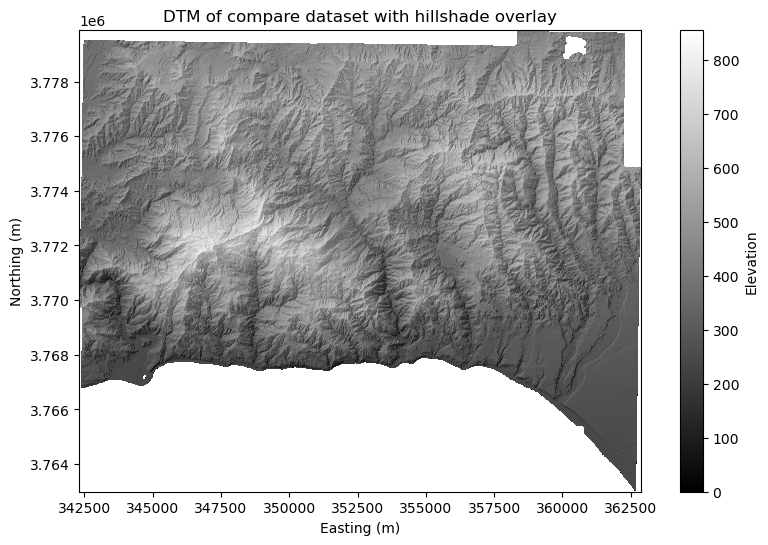

In [6]:
dem_path = compare_dtm
hillshade_path = hillshade_compare_dtm
title = "DTM of compare dataset with hillshade overlay"
colormap = "gray"
transparency_level = 0.4

plot_hillshade(dem_path, hillshade_path, title, colormap, transparency_level)

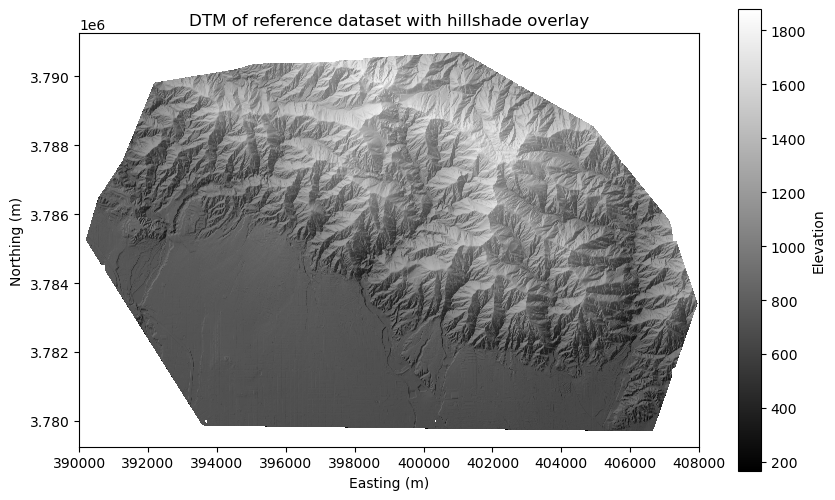

In [10]:
dem_path = reference_dtm
hillshade_path = hillshade_reference_dtm
title = "DTM of reference dataset with hillshade overlay"
colormap = "gray"
transparency_level = 0.4

plot_hillshade(dem_path, hillshade_path, title, colormap, transparency_level)

### Slope

In [6]:
# Paths to your input DEM and output slope files
slope_compare_dtm = data_path+'slope_dtm_compare.tif'
slope_compare_dsm = data_path+'slope_dsm_compare.tif'
slope_reference_dtm = data_path+'slope_dtm_reference.tif'
slope_reference_dsm = data_path+'slope_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_slope(compare_dtm, slope_compare_dtm)
calculate_slope(compare_dsm, slope_compare_dsm)
calculate_slope(reference_dtm, slope_reference_dtm)
calculate_slope(reference_dsm, slope_reference_dsm)

#### Plot

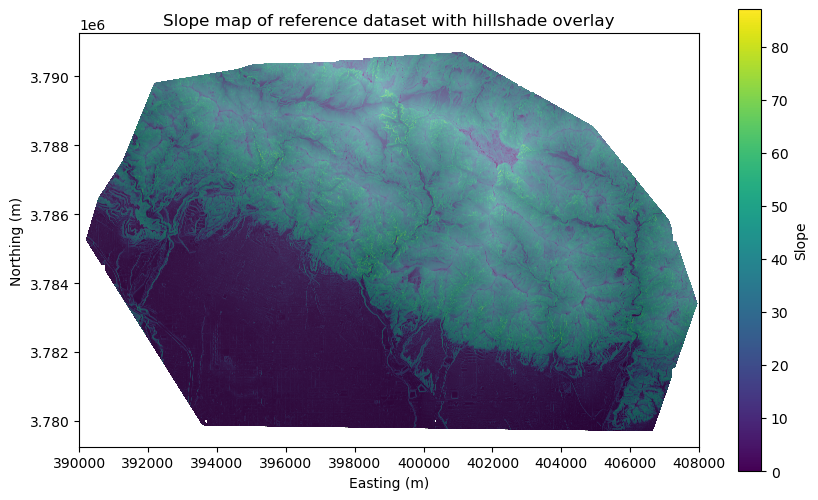

In [12]:
dem_path = reference_dtm
slope_path = slope_reference_dtm
title = "Slope map of reference dataset with hillshade overlay"
colormap = "viridis"
transparency_level = 0.4

plot_slope(dem_path, slope_path, title, colormap, transparency_level)

### Roughness

In [7]:
# Paths to your input DEM and output slope files
roughness_compare_dtm = data_path+'roughness_dtm_compare.tif'
roughness_compare_dsm = data_path+'roughness_dsm_compare.tif'
roughness_reference_dtm = data_path+'roughness_dtm_reference.tif'
roughness_reference_dsm = data_path+'roughness_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_roughness(compare_dtm, roughness_compare_dtm)
calculate_roughness(compare_dsm, roughness_compare_dsm)
calculate_roughness(reference_dtm, roughness_reference_dtm)
calculate_roughness(reference_dsm, roughness_reference_dsm)

#### Plot

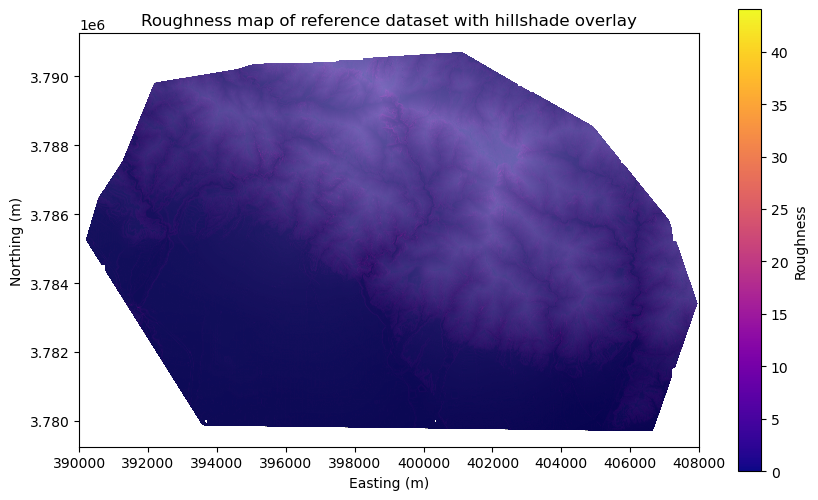

In [14]:
dem_path = reference_dtm
roughness_path = roughness_reference_dtm
title = "Roughness map of reference dataset with hillshade overlay"
colormap = "plasma"
transparency_level = 0.4

plot_roughness(dem_path, roughness_path, title, colormap, transparency_level)

### Aspect

In [8]:
# Paths to your input DEM and output slope files
aspect_compare_dtm = data_path+'aspect_dtm_compare.tif'
aspect_compare_dsm = data_path+'aspect_dsm_compare.tif'
aspect_reference_dtm = data_path+'aspect_dtm_reference.tif'
aspect_reference_dsm = data_path+'aspect_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_aspect(compare_dtm, aspect_compare_dtm)
calculate_aspect(compare_dsm, aspect_compare_dsm)
calculate_aspect(reference_dtm, aspect_reference_dtm)
calculate_aspect(reference_dsm, aspect_reference_dsm)

#### Plot

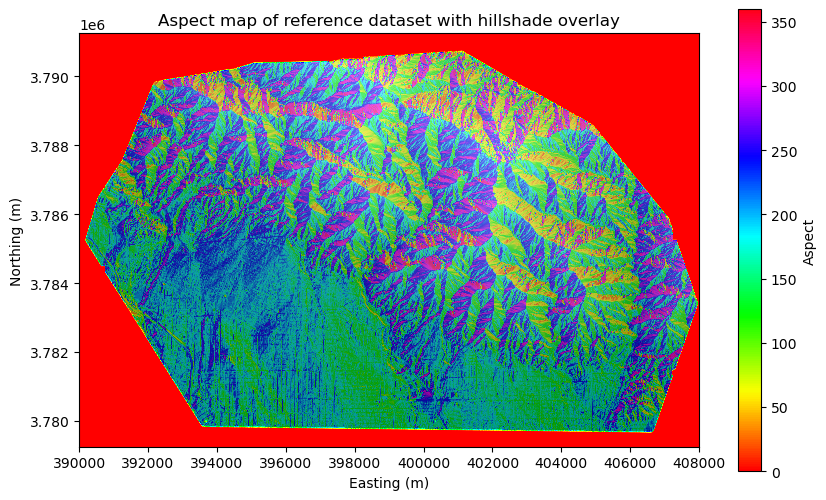

In [16]:
dem_path = reference_dtm
aspect_path = aspect_reference_dtm
title = "Aspect map of reference dataset with hillshade overlay"
colormap = "hsv"
transparency_level = 0.4

plot_aspect(dem_path, aspect_path, title, colormap, transparency_level)

### Canopy height models (compare and reference) 

First lets make sure the `compare_dtm`, `reference_dtm`, `compare_dsm`, `reference_dsm`, `compare_chm_rio`, and `reference_chm_rio` variables are not already present in memory. This would be the case if you have already run this notebook to completion. If they are, the next cell will delete them. This is necessary due to the way that `rioxarray` allocates memory. If you don't close and delete the variables, they will remain in memory which can be frustrating and confusing.

In [9]:
try: 
    compare_dtm.close()
    reference_dtm.close()
    compare_dsm.close()
    reference_dsm.close()
    compare_chm_rio.close()
    reference_dsm_rio.close()
    del compare_dtm
    del reference_dtm
    del compare_dsm
    del reference_dsm
    del compare_chm_rio
    del reference_dsm_rio
except:
    pass

In [10]:
# Open the DTM and DSM files with rasterio, using masks for invalid data
compare_dtm_rio = rio.open_rasterio(compare_dtm, masked=True) 
compare_dsm_rio = rio.open_rasterio(compare_dsm, masked=True)

if compare_dtm_rio.shape == compare_dsm_rio.shape:
    print('DTMs have the same shape. Proceed to the next step.')
elif compare_dtm_rio.shape > compare_dsm_rio.shape:
    small = compare_dsm
    large = compare_dtm
    compare_dtm_rio = compare_dtm_rio.rio.reproject_match(compare_dsm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))
else:
    small = compare_dtm
    large = compare_dsm
    compare_dsm_rio = compare_dsm_rio.rio.reproject_match(compare_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))

# Reassign the coordinates of the DTM to match those of the DSM
compare_dtm_rio = compare_dtm_rio.assign_coords({
    "x": compare_dsm_rio.x,
    "y": compare_dsm_rio.y,
})

# Calculate the Canopy Height Model (CHM) by subtracting the DTM from the DSM
compare_chm_rio = compare_dsm_rio - compare_dtm_rio 
compare_chm_rio.compute()

# Define the path for the output CHM file
compare_chm = data_path + "compare_chm.tif"

# Save the computed CHM to a raster file
compare_chm_rio.rio.to_raster(compare_chm)

DTMs have the same shape. Proceed to the next step.


In [11]:
# Open the reference DTM and DSM files with rasterio, using masks for invalid data
reference_dtm_rio = rio.open_rasterio(reference_dtm, masked=True) 
reference_dsm_rio = rio.open_rasterio(reference_dsm, masked=True)

if reference_dtm_rio.shape == reference_dsm_rio.shape:
    print('DTMs have the same shape. Proceed to the next step.')
elif compare_dtm_rio.shape > reference_dsm_rio.shape:
    small = reference_dsm
    large = reference_dtm
    reference_dtm_rio = reference_dtm_rio.rio.reproject_match(reference_dsm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))
else:
    small = reference_dtm
    large = reference_dsm
    reference_dsm_rio = reference_dsm_rio.rio.reproject_match(reference_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))

# Reassign the coordinates of the reference DTM to match those of the reference DSM
reference_dtm_rio = reference_dtm_rio.assign_coords({
    "x": reference_dsm_rio.x,
    "y": reference_dsm_rio.y,
})

# Calculate the reference Canopy Height Model (CHM) by subtracting the reference DTM from the reference DSM
reference_chm_rio = reference_dsm_rio - reference_dtm_rio 
reference_chm_rio.compute()

# Define the path for the output reference CHM file
reference_chm = data_path + "reference_chm.tif"

# Save the computed reference CHM to a raster file
reference_chm_rio.rio.to_raster(reference_chm)

DTMs have the same shape. Proceed to the next step.


#### Plot

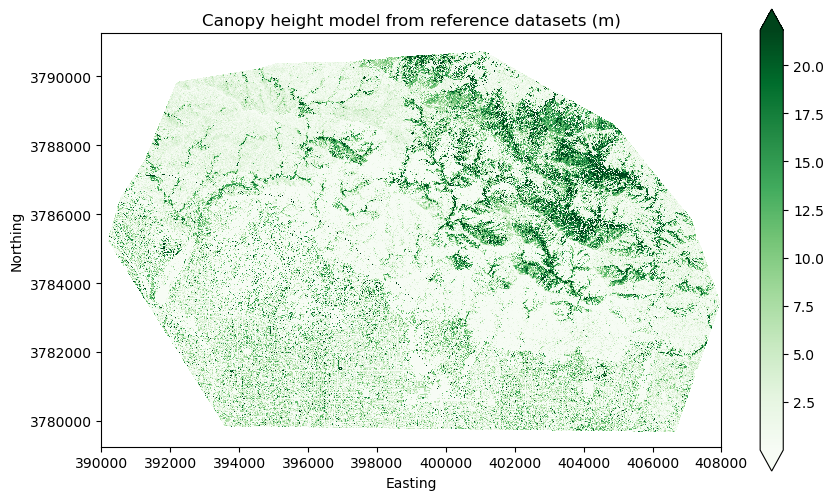

In [20]:
fig,ax=plt.subplots(figsize=(10, 6))
reference_chm_rio.plot(ax=ax,cmap="Greens", robust=True)
ax.set_title("Canopy height model from reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

## Calculate Topographic Change with Raster Math
The following section is taken from <a href="https://github.com/cmspeed/OT_3DEP_Workflows/blob/main/notebooks/06_3DEP_Topographic_Differencing.ipynb">a notebook by Speed et al. (2022)</a>  

### Differencing DTMs

Again, lets make sure the `compare_dtm`, `reference_dtm`, and `topo_diff` variables are not already present in memory.

In [12]:
try: 
    compare_dtm_rio.close()
    reference_dtm_rio.close()
    topo_diff_dtm.close()
    del compare_dtm_rio
    del reference_dtm_rio
    del topo_diff_dtm
except:
    pass

In [13]:
compare_dtm_rio = rio.open_rasterio(compare_dtm, masked=True) 
reference_dtm_rio = rio.open_rasterio(reference_dtm, masked=True)

Raster math operations generally are performed on rasters that have the same dimensions (height and width in pixels, including pixels with NoData values). Frequently, `compare_dtm_rio` and `reference_dtm_rio` have different shapes, even thought the extent we used was the same. This happens for a variety of reasons, but it is true in almost every case. Lets quickly print the shape of each DTM to see what their shapes are.

In [14]:
print("Compare DTM has shape:", compare_dtm_rio.shape)
print("Reference DTM has shape:", reference_dtm_rio.shape)

Compare DTM has shape: (1, 12000, 18000)
Reference DTM has shape: (1, 12000, 18000)


The two DTMs should have the same number of bands (1), but sometimes, they will differ in the number of pixels in the x and y directions. We need to remedy this before proceeding with the raster math calculation.

If the rasters are different shapes, the extent of the smaller of the two rasters will be used to clip the extent of the larger raster. If they are the same shape, we will leave them as is. In the following cell we use a series of 'if' statements to test the shape of the rasters. If there is a difference in shape, the `rio.reproject_match()` function is used to clip the raster, resulting in both rasters having the same extent.

In [15]:
if compare_dtm_rio.shape == reference_dtm_rio.shape:
    print('DTMs have the same shape. Proceed to the next step.')
elif compare_dtm_rio.shape > reference_dtm_rio.shape:
    small = reference_dtm
    large = compare_dtm
    compare_dtm_rio = compare_dtm_rio.rio.reproject_match(reference_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))
else:
    small = compare_dtm
    large = reference_dtm
    reference_dtm_rio = reference_dtm_rio.rio.reproject_match(compare_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))


DTMs have the same shape. Proceed to the next step.


Let's do a quick check to confirm that the rasters are the same size now.

In [16]:
print("Compare DTM has shape:", compare_dtm_rio.shape)
print("Reference DTM has shape:", reference_dtm_rio.shape)

Compare DTM has shape: (1, 12000, 18000)
Reference DTM has shape: (1, 12000, 18000)


Hopefully, your rasters now have the same extent. The last thing to ensure that the topographic differnce can be computed with the two DTMs is to make sure the extent of the rasters have exactly the same coordinates.

In [17]:
compare_dtm_rio = compare_dtm_rio.assign_coords({
    "x": reference_dtm_rio.x,
    "y": reference_dtm_rio.y,
})

Now, it's time to perform raster math by differencing the two DTMs. For the output to make physical sense, the rasters should be differenced as follows: `topo_diff = new_dtm - old_dtm`. Positive values of the `topo_diff` raster will indicate that land surface gained elevation, whereas negative values will indicate land surface elevation loss.

In [18]:
topo_diff_dtm = reference_dtm_rio - compare_dtm_rio
topo_diff_dtm.compute()
topo_diff_path_dtm=data_path+"topo_diff_dtm.tif"
topo_diff_dtm.rio.to_raster(topo_diff_path_dtm)

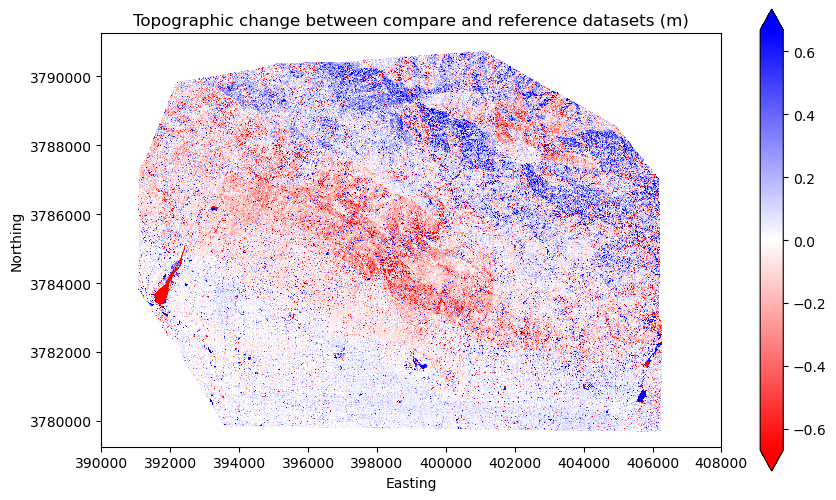

In [19]:
fig,ax=plt.subplots(figsize=(10, 6))
topo_diff_dtm.plot(ax=ax,cmap="bwr_r", robust=True)
ax.set_title("Topographic change between compare and reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

### Differencing DSMs

In [20]:
try: 
    compare_dsm_rio.close()
    reference_dsm_rio.close()
    topo_diff_dsm.close()
    del compare_dsm_rio
    del reference_dsm_rio
    del topo_diff_dsm
except:
    pass

In [21]:
compare_dsm_rio = rio.open_rasterio(compare_dsm, masked=True) 
reference_dsm_rio = rio.open_rasterio(reference_dsm, masked=True)

In [22]:
print("Compare DSM has shape:", compare_dsm_rio.shape)
print("Reference DSM has shape:", reference_dsm_rio.shape)

Compare DSM has shape: (1, 12000, 18000)
Reference DSM has shape: (1, 12000, 18000)


In [23]:
if compare_dsm_rio.shape == reference_dsm_rio.shape:
    print('DSMs have the same shape. Proceed to the next step.')
elif compare_dsm_rio.shape > reference_dsm_rio.shape:
    small = reference_dsm
    large = compare_dsm
    compare_dsm_rio = compare_dsm_rio.rio.reproject_match(reference_dsm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))
else:
    small = compare_dsm
    large = reference_dsm
    reference_dsm_rio = reference_dsm_rio.rio.reproject_match(compare_dsm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))


DSMs have the same shape. Proceed to the next step.


In [24]:
print("Compare DSM has shape:", compare_dsm_rio.shape)
print("Reference DSM has shape:", reference_dsm_rio.shape)

Compare DSM has shape: (1, 12000, 18000)
Reference DSM has shape: (1, 12000, 18000)


In [25]:
compare_dsm_rio = compare_dsm_rio.assign_coords({
    "x": reference_dsm_rio.x,
    "y": reference_dsm_rio.y,
})

In [26]:
topo_diff_dsm = reference_dsm_rio - compare_dsm_rio
topo_diff_dsm.compute()
topo_diff_path_dsm=data_path+"topo_diff_dsm.tif"
topo_diff_dsm.rio.to_raster(topo_diff_path_dsm)

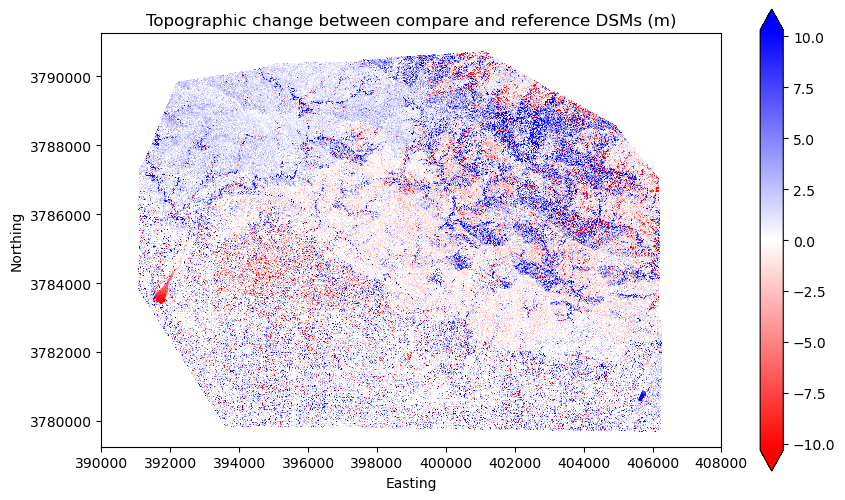

In [27]:
fig,ax=plt.subplots(figsize=(10, 6))
topo_diff_dsm.plot(ax=ax,cmap="bwr_r", robust=True)
ax.set_title("Topographic change between compare and reference DSMs (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

## Export PNG of topographic differencing results

In [28]:
try: 
    compare_dtm_rio.close()
    reference_dtm_rio.close()
    topo_diff_dtm.close()
    del compare_dtm_rio
    del reference_dtm_rio
    del topo_diff_dtm
except:
    pass

In [29]:
topo_diff_path_dtm

'/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/LA fires/Corrected/Eaton/topo_diff_dtm.tif'

In [30]:
# Open the topographic difference raster and hillshade DEM raster with rasterio, using masks for invalid data
topo_diff = rio.open_rasterio(topo_diff_path_dtm, masked=True) 
hillshade_compare_dtm_rio = rio.open_rasterio(hillshade_compare_dtm, masked=True)

# Determine which raster has a larger shape
if topo_diff.shape > hillshade_compare_dtm_rio.shape:
    small = hillshade_compare_dtm
    large = topo_diff_path_dtm
    # Reproject the larger raster to match the smaller raster's grid
    topo_diff = topo_diff.rio.reproject_match(hillshade_compare_dtm_rio)
else:
    small = topo_diff_path_dtm
    large = hillshade_compare_dtm
    # Reproject the larger raster to match the smaller raster's grid
    hillshade_compare_dtm_rio = hillshade_compare_dtm_rio.rio.reproject_match(topo_diff)

# Define paths for cropped rasters
topo_diff_path_cropped = data_path + 'topo_diff_cropped_DTMs.tif'
hillshade_compare_dtm_path_cropped = data_path + 'hillshade_compare_dtm_cropped.tif'

# Save the reprojected rasters to new files
topo_diff.rio.to_raster(topo_diff_path_cropped)
hillshade_compare_dtm_rio.rio.to_raster(hillshade_compare_dtm_path_cropped)

# Define paths for reprojected rasters in EPSG:3857
topo_diff_path_cropped_3857 = data_path + 'topo_diff_cropped_epsg3857_DTMs.tif'
hillshade_compare_dtm_path_cropped_3857 = data_path + 'hillshade_compare_dtm_cropped_epsg3857.tif'

# Reproject the cropped rasters to EPSG:3857
reproject_for_map(topo_diff_path_cropped, topo_diff_path_cropped_3857)
reproject_for_map(hillshade_compare_dtm_path_cropped, hillshade_compare_dtm_path_cropped_3857)

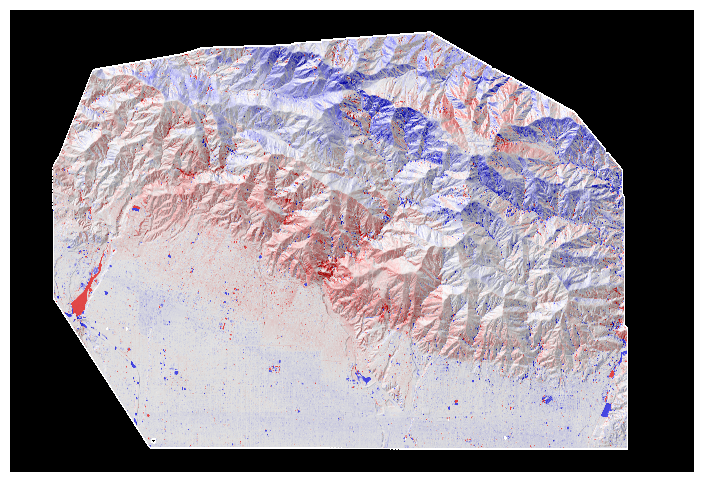

In [31]:
# Load the differencing data
with rasterio.open(topo_diff_path_cropped_3857, 'r+') as diff:
    # Set NoData value to NaN and read the data as a masked array
    diff.nodata = np.nan
    topo_diff = diff.read(1, masked=True)
    diff_extent = [diff.bounds.left, diff.bounds.right, diff.bounds.bottom, diff.bounds.top]
    # Extract mask from the topo_diff array
    topo_diff_mask = np.ma.getmask(topo_diff)
    # Read the mask from the raster file
    topo_mask = diff.read_masks(1)

# Load the hillshade data
with rasterio.open(hillshade_compare_dtm_path_cropped_3857) as data:
    hillshade = data.read(1, masked=True)
    # Read the mask from the hillshade raster file
    hill_mask = data.read_masks(1)

# Combine the masks from both datasets
combined_mask = np.logical_and(topo_mask, hill_mask)
inverse_mask = np.logical_not(combined_mask)

# Apply the combined mask to both datasets
topo_diff = np.ma.masked_where(inverse_mask, topo_diff, np.nan)
hillshade = np.ma.masked_where(inverse_mask, hillshade, np.nan)

# Plot the topographic differencing with colormap
fig, ax = plt.subplots(figsize=(10, 6))

# Get colormap bounds for the topo_diff array
vmin, vmax = get_colormap_bounds(topo_diff) 
cmap_diff = plt.get_cmap('bwr_r')
cmap_diff.set_bad(color='none')  # Ensure masked areas in topo_diff are not colored

# Normalize color
norm = Normalize(vmin=vmin, vmax=vmax)

# Display topographic differences
ax.imshow(topo_diff, cmap=cmap_diff, norm=norm, extent=diff_extent)

# Overlay the hillshade with the differencing results as a transparency layer
cmap_shade = plt.get_cmap('gray')
cmap_shade.set_bad(color='none')  # Ensure masked areas in hillshade are also not colored

ax.imshow(hillshade, cmap=cmap_shade, alpha=0.4, extent=diff_extent)

# Plot the combined mask as its own layer
cmap_mask = plt.get_cmap('gray')  # Use a simple grayscale for the mask visualization
mask_display = np.where(inverse_mask, 1, np.nan)  # Convert boolean mask to a displayable format
ax.imshow(mask_display, cmap=cmap_mask, extent=diff_extent)

# Customize plot aesthetics
ax.axis('off')  # Remove axes border, ticks, and labels

# Save or show the plot
plt.savefig(data_path + 'topo_diff_DTMs.png', dpi=1200, bbox_inches='tight', pad_inches=0) 
plt.show()

In [32]:
# Specify the path for the new masked raster file
mask_raster_path = data_path+'nodata_mask_compare_raster_DTMs.tif'

# Open the original raster file to use its metadata for the new raster
with rasterio.open(topo_diff_path_cropped) as src:
    # Update the metadata for the new raster
    meta = src.meta.copy()
    meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0  # Assuming 0 for no-data in the mask; adjust as necessary
    })

    # Create a new raster file with the combined mask
    with rasterio.open(mask_raster_path, 'w', **meta) as dst:
        # Write the inverse mask to the raster, converting boolean to uint8
        dst.write(inverse_mask.astype('uint8') * 255, 1)  

In [33]:
try: 
    compare_dsm_rio.close()
    reference_dsm_rio.close()
    topo_diff_dsm.close()
    del compare_dsm_rio
    del reference_dsm_rio
    del topo_diff_dsm
except:
    pass

In [34]:
# Open the topographic difference raster and hillshade DEM raster with rasterio, using masks for invalid data
topo_diff = rio.open_rasterio(topo_diff_path_dsm, masked=True) 
hillshade_compare_dsm_rio = rio.open_rasterio(hillshade_compare_dsm, masked=True)

# Determine which raster has a larger shape
if topo_diff.shape > hillshade_compare_dsm_rio.shape:
    small = hillshade_compare_dsm
    large = topo_diff_path_dsm
    # Reproject the larger raster to match the smaller raster's grid
    topo_diff = topo_diff.rio.reproject_match(hillshade_compare_dsm_rio)
else:
    small = topo_diff_path_dsm
    large = hillshade_compare_dsm
    # Reproject the larger raster to match the smaller raster's grid
    hillshade_compare_dsm_rio = hillshade_compare_dsm_rio.rio.reproject_match(topo_diff)

# Define paths for cropped rasters
topo_diff_path_cropped = data_path + 'topo_diff_cropped_DSMs.tif'
hillshade_compare_dsm_path_cropped = data_path + 'hillshade_compare_dsm_cropped.tif'

# Save the reprojected rasters to new files
topo_diff.rio.to_raster(topo_diff_path_cropped)
hillshade_compare_dsm_rio.rio.to_raster(hillshade_compare_dsm_path_cropped)

# Define paths for reprojected rasters in EPSG:3857
topo_diff_path_cropped_3857 = data_path + 'topo_diff_cropped_epsg3857_DSMs.tif'
hillshade_compare_dsm_path_cropped_3857 = data_path + 'hillshade_compare_dsm_cropped_epsg3857.tif'

# Reproject the cropped rasters to EPSG:3857
reproject_for_map(topo_diff_path_cropped, topo_diff_path_cropped_3857)
reproject_for_map(hillshade_compare_dsm_path_cropped, hillshade_compare_dsm_path_cropped_3857)

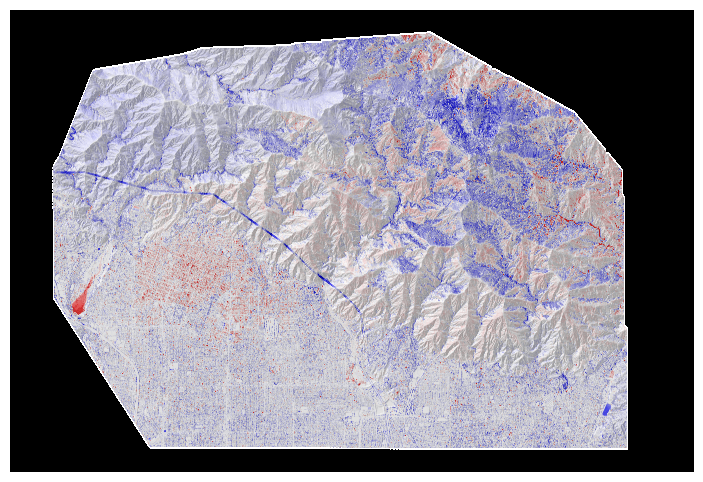

In [35]:
# Load the differencing data
with rasterio.open(topo_diff_path_cropped_3857, 'r+') as diff:
    # Set NoData value to NaN and read the data as a masked array
    diff.nodata = np.nan
    topo_diff = diff.read(1, masked=True)
    diff_extent = [diff.bounds.left, diff.bounds.right, diff.bounds.bottom, diff.bounds.top]
    # Extract mask from the topo_diff array
    topo_diff_mask = np.ma.getmask(topo_diff)
    # Read the mask from the raster file
    topo_mask = diff.read_masks(1)

# Load the hillshade data
with rasterio.open(hillshade_compare_dsm_path_cropped_3857) as data:
    hillshade = data.read(1, masked=True)
    # Read the mask from the hillshade raster file
    hill_mask = data.read_masks(1)

# Combine the masks from both datasets
combined_mask = np.logical_and(topo_mask, hill_mask)
inverse_mask = np.logical_not(combined_mask)

# Apply the combined mask to both datasets
topo_diff = np.ma.masked_where(inverse_mask, topo_diff, np.nan)
hillshade = np.ma.masked_where(inverse_mask, hillshade, np.nan)

# Plot the topographic differencing with colormap
fig, ax = plt.subplots(figsize=(10, 6))

# Get colormap bounds for the topo_diff array
vmin, vmax = get_colormap_bounds(topo_diff) 
cmap_diff = plt.get_cmap('bwr_r')
cmap_diff.set_bad(color='none')  # Ensure masked areas in topo_diff are not colored

# Normalize color
norm = Normalize(vmin=vmin, vmax=vmax)

# Display topographic differences
ax.imshow(topo_diff, cmap=cmap_diff, norm=norm, extent=diff_extent)

# Overlay the hillshade with the differencing results as a transparency layer
cmap_shade = plt.get_cmap('gray')
cmap_shade.set_bad(color='none')  # Ensure masked areas in hillshade are also not colored

ax.imshow(hillshade, cmap=cmap_shade, alpha=0.4, extent=diff_extent)

# Plot the combined mask as its own layer
cmap_mask = plt.get_cmap('gray')  # Use a simple grayscale for the mask visualization
mask_display = np.where(inverse_mask, 1, np.nan)  # Convert boolean mask to a displayable format
ax.imshow(mask_display, cmap=cmap_mask, extent=diff_extent)

# Customize plot aesthetics
ax.axis('off')  # Remove axes border, ticks, and labels

# Save or show the plot
plt.savefig(data_path + 'topo_diff_DSMs.png', dpi=1200, bbox_inches='tight', pad_inches=0) 
plt.show()

In [36]:
# Specify the path for the new masked raster file
mask_raster_path = data_path+'nodata_mask_compare_raster_DSMs.tif'

# Open the original raster file to use its metadata for the new raster
with rasterio.open(topo_diff_path_cropped) as src:
    # Update the metadata for the new raster
    meta = src.meta.copy()
    meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0  # Assuming 0 for no-data in the mask; adjust as necessary
    })

    # Create a new raster file with the combined mask
    with rasterio.open(mask_raster_path, 'w', **meta) as dst:
        # Write the inverse mask to the raster, converting boolean to uint8
        dst.write(inverse_mask.astype('uint8') * 255, 1)  